# **Task-1**

### Information about this notebook

##### 1. Optimization has been done starting from circuit with 1 layer upto circuit with 12 layers.
##### 2. For Each circuit with specific no. of layers, distance calculated in each iteration has been printed and plotted also.
##### 3. Finally the minimum distance in the circuit has been plotted as a function of no. of layers used in that circuit.
##### 4. Also the no. of iteration used and the time taken for optimization is also plotted as a function of no. of layers.

### Note - In this notebook seperate cells has been dedicated for each circuit and finally in the last part, information like minimum distance from all circuits has been put together ans plotted. 
### In the another notebook, all the circuits has been put together by looping over the no. of layers, and finally overall plots has been shown (no seperate plot for each circuit has been shown there). 

## The block below executes to do all the necessary imports

In [4]:
import numpy as np
import pennylane as qml

from pennylane import expval, var
from matplotlib import pyplot as plt

import time

## initialize_theta()
#### Arguments - only a single arg, no. of layers in the circuit
#### It randomly generates a numpy array having (layers X 2) no. of rows and 4 columns
#### Each element in the np array is a theta value for a parameterized gate ranging from (0,2pi)
#### Return - numpy array

In [7]:
pi = np.pi
def initialize_theta(layers):
    
    row = layers*2
    column = 4
    theta = np.random.uniform(low=0, high=2*pi, size=(row, column))
    
    return theta

## initialize_random_phi()
#### Arguments - no args is passed
#### as the phi is used as reference with the circuit output, it returns an numpy array having same dimension of statevector returned by the circuit
#### Since the circuit has 4 wires, statevector will have 2^4 or 16 elements

In [4]:
# This function returns a random valued numpy array phi, with respect to which distance of the quantum circuit will be calculated
# dimension of phi will be same as the dimension of np array returned by simulate_circuit() 
def initialize_random_phi():
    phi = np.random.randn(16,)
    return phi

## simulate_circuit()
#### Arguments - the numpy array containing all the parameters for each gate
#### Creates a object of device class using required attributes
#### calls the circuit() function defined inside it to generate the specific circuit using paramaters passed
#### Return - returns the output statevector of the simulated circuit using dev.state

In [5]:
def simulate_circuit(theta):
    dev = qml.device("default.qubit", wires=4)

    @qml.qnode(dev)
    def circuit(theta):
    #This circuit function genrates the quantum circuit. It takes only the parameters theta as the argument
    
        #The no. of layers has not to be passed explicitely, as it is calculated from dimension of theta here
        layers = theta.shape[0] // 2

        for i in range(layers):

            # yellow block
            for j in range(4): #This loops over all four qubits and apply RX gate with proper param extracted from theta
                qml.RX(theta[2*i][j], wires=j)

            # Green block
            for j in range(4): #THis loops over all 4 qubits and apply RZ gate with proper param extracted from theta
                qml.RZ(theta[(2*i)+1][j], wires=j)

            for control in range(3): # Double qubit CZ gates has been applied here
                for target in range(control+1, 4):
                    qml.CZ(wires=[control, target])

        # this pauliZ measured values are not used but has to be returned because circuit() function can't return None
        return qml.expval(qml.PauliZ(wires=0)),  qml.expval(qml.PauliZ(wires=1)), qml.expval(qml.PauliZ(wires=2)), qml.expval(qml.PauliZ(wires=3))
       
    circuit(theta)
    
    #returns the 2^4 = 16 dimensioned output statevector of the simulated circuit
    return dev.state

## calc_distance()
#### Arguments - takes only the numpy array containing parameters for all parameterized gates in the circuit
#### it calls the function simulate_circuit(), which returns the statevector psi_of_theta
#### now it calculates the difference of psi_of_theta and phi (phi has been initialized globally and used the same for all the circuit in this notebook)
#### Finally the sum of square of mod of all 16 complex numbers has been calculated 
#### Return - a single float value which is calculated, mentioned above

In [8]:
# This function takes the theta, calls the simulate_circuit() func and calculates the distance of vector returned 
# by the simulate_circuit() with respect to global variable psi
def calc_distance(theta):
    
    psi_of_theta = simulate_circuit(theta) 
    diff = psi_of_theta - phi #phi is the global one here, used for all the layers
    mod_sqr = diff.real**2 + diff.imag**2
    distance = np.sum(mod_sqr) #calculates the sum of squares of mod of difference between corresponding elements of psi and phi
    
    # returns the distance (as mentioned in the problem statement)
    return distance

## optimize()
#### Arguments - np array of all parameters, maximum no. of iteration used and two optional boolean parameters- print_distance, plot_distance
#### *Imp. point to note - although iteration is passed as a parameter in the function, but there is a callback used below, which terminates the optimization when three consecutive calculated distance is same(upto 2 decimal places) considering the fact that minimum distance has been achieved*
#### the RotosolveOptimizer available in pennylane has been used here to optimize the parameters to get the minimum distance for each circuit
#### while calling the function, if print_distance is set as True, it prints the distance calculated in each iteration
#### if the plot_distance is also set True, it will plot the calculated distance vs iteration after the optimization of a specific circuit is completed
#### Returns - a dict containing minimum_distance calculated after the optimization, no. of iteration used and optimized parameters value

In [25]:
# this takes params of the circuit, iteratioin as necessary arguments
# also two optional args to print and plot the distance for each layer count
def optimize(theta, iterations, print_distance=False, plot_distance=False):
    
    
    distance_hist = [] #keeps track of distance after each iterations
    
    optimizer = qml.optimize.RotosolveOptimizer() 
    
    # callback: this flag is initialized to keep track of repeating distances, which is further used to terminate the iteration
    # when optimization is completed approx
    flag = 0
    
    print("Optimizing\n", end='')
    
    for i in range(iterations): 
        theta = optimizer.step(calc_distance, theta)
        distance = calc_distance(theta) #calls the calc_distance() to calculate distance of the circuit
        print('.', end='')
        
        # this code chunk is used to compare current distance with the previous one to check repetations
        if(len(distance_hist)>0):
            if(round(distance_hist[-1],2)==round(distance,2)): #here upto 2 decimal places round off has been done
                flag += 1
            else:
                flag = 0
        distance_hist.append(distance)
        if(print_distance):
            print("Iteration=> "+str(i)+", distance=> "+str(distance))
        
        # Whenever flag becomes 3, means 3 times same distance has been calculated, we can assume the params to be
        # optimized and can terminate the optimization
        if(flag == 3):
            break
    
    print('\nOptimization Completed')
        
        
    if(plot_distance):
        plt.style.use("seaborn")
        plt.plot(distance_hist, "b", label="Optimization")
        plt.ylabel("Distance value")
        plt.xlabel("Optimization steps")
        plt.legend()
        plt.show()
    
    #returns the final_cost, maximum iteration used and optimized parameter values
    cache = {"min_distance": distance_hist[-1],
             "iter": i+1,
             "optimized_theta": theta}
    
    return cache

## The below cell initializes the phi globally, which will be used as a referrence for the statevector returned by each circuit by calculating the distance w.r.t phi

In [10]:
phi = initialize_random_phi() #initialized a vector phi as a referenc of cost for the whole process

## Four lists initializd below will store various data returned by each circuit simulated.

## simulate()
#### Argument - a single argument, which is the no. of layers used in the quantum circuit
#### initializes random parameters, calls the optimize function to optimize the parameters to get minimum value of distance
#### finally prints some information about each circuit after optimization - minimum distance, no. of iteration used and time taken for the optimization
#### *also print_distance, plot_distance parameter being True while calling the optimize function, distance at each step of iteration and a plot showing overall decrement in distance will also be printed*
#### Returns nothing

In [34]:
min_distance_list = [] # it will store the minimum distance of circuit for each circuit
iter_list = [] # it will store no. of iterations used for each circuit
optimized_theta_list = [] #similarly stores the optimized params for each circuit
time_list = [] #stores total time of optimization for each circuit

def simulate(layer):
    theta = initialize_theta(layer) #initializes random theta values which will be optimized further

    start = time.time()
    
    # calls the optimize() function which will first create a circuit with the passed theta values 
    # then optimize the parameters using RotosolveOptimizer() algorithm and finally returns min_distance, iteration used and optimized params
    # although the iteration is initialized as 50, if it fulfils the callback condition, it will be terminated earlier
    cache = optimize(theta, 50, print_distance=True, plot_distance=True)
    
    time_taken = time.time() - start

    iter_list.append(cache['iter'])
    min_distance_list.append(cache['min_distance'])
    time_list.append(time_taken)

    print("\n_______________________________________")
    print("_______________________________________")
    print("\n\n Layer count in Circuit => "+str(layer))
    print("\n Iteration used => "+str(cache['iter']))
    print(" Minimum distance => "+str(cache['min_distance']))
    print(" Time taken for optimization (minute) => "+str(time_taken/60))

# No. of Layers in the circuit = 1

Optimizing
.Iteration=> 0, distance=> 21.112789654841208
.Iteration=> 1, distance=> 19.66719729812145
.Iteration=> 2, distance=> 17.572344311217105
.Iteration=> 3, distance=> 17.336418222974302
.Iteration=> 4, distance=> 17.160999063865326
.Iteration=> 5, distance=> 17.066363251195433
.Iteration=> 6, distance=> 17.02584143892554
.Iteration=> 7, distance=> 17.011022743209164
.Iteration=> 8, distance=> 17.00588934177419
.Iteration=> 9, distance=> 17.004166979249938
.Iteration=> 10, distance=> 17.0035996881762
.Iteration=> 11, distance=> 17.003414481068916
.Iteration=> 12, distance=> 17.0033542359512

Optimization Completed


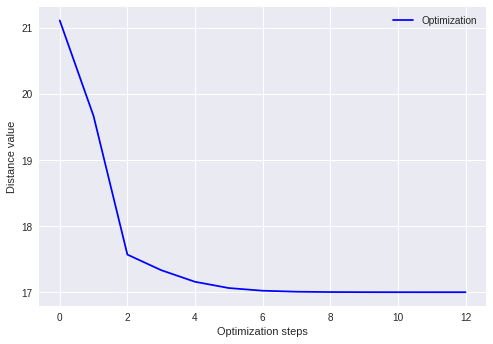


_______________________________________
_______________________________________


 Layer count in Circuit => 1

 Iteration used => 13
 Minimum distance => 17.0033542359512
 Time taken for optimization (minute) => 0.040975439548492434


In [35]:
layer = 1
simulate(layer)

# No. of Layers in the circuit = 2

Optimizing
.Iteration=> 0, distance=> 19.37165317493055
.Iteration=> 1, distance=> 17.832902450449865
.Iteration=> 2, distance=> 15.796000492506135
.Iteration=> 3, distance=> 15.23896837356393
.Iteration=> 4, distance=> 15.104178635069307
.Iteration=> 5, distance=> 15.046652260888354
.Iteration=> 6, distance=> 15.01684370080339
.Iteration=> 7, distance=> 14.998065559750982
.Iteration=> 8, distance=> 14.98303652625657
.Iteration=> 9, distance=> 14.966286062138057
.Iteration=> 10, distance=> 14.94008941354409
.Iteration=> 11, distance=> 14.891074582795609
.Iteration=> 12, distance=> 14.810401662048596
.Iteration=> 13, distance=> 14.730725530778647
.Iteration=> 14, distance=> 14.69013358909547
.Iteration=> 15, distance=> 14.674967799006453
.Iteration=> 16, distance=> 14.66715149419744
.Iteration=> 17, distance=> 14.659892065669546
.Iteration=> 18, distance=> 14.652451085922518
.Iteration=> 19, distance=> 14.645200872796075
.Iteration=> 20, distance=> 14.63823467920399
.Iteration=> 21, dis

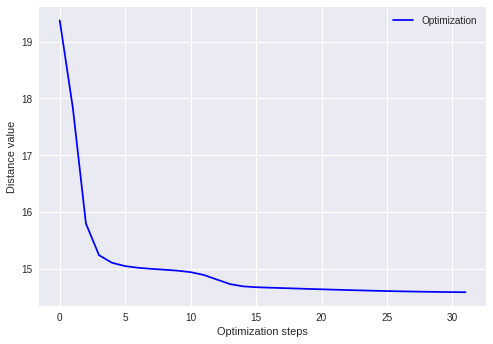


_______________________________________
_______________________________________


 Layer count in Circuit => 2

 Iteration used => 32
 Minimum distance => 14.587057467386952
 Time taken for optimization (minute) => 0.4809211214383443


In [38]:
layer = 2
simulate(layer)

# No. of Layers in the circuit = 3

Optimizing
.Iteration=> 0, distance=> 21.10790217011815
.Iteration=> 1, distance=> 19.500602846097657
.Iteration=> 2, distance=> 16.535226780193945
.Iteration=> 3, distance=> 15.735232678539127
.Iteration=> 4, distance=> 14.507710729036816
.Iteration=> 5, distance=> 14.146966624388977
.Iteration=> 6, distance=> 14.10674071457234
.Iteration=> 7, distance=> 14.098388464663584
.Iteration=> 8, distance=> 14.094904511329737
.Iteration=> 9, distance=> 14.090628586498717
.Iteration=> 10, distance=> 14.085160243545934
.Iteration=> 11, distance=> 14.079040290151298
.Iteration=> 12, distance=> 14.072519964405004
.Iteration=> 13, distance=> 14.06527980040547
.Iteration=> 14, distance=> 14.05598742845339
.Iteration=> 15, distance=> 14.041300012263804
.Iteration=> 16, distance=> 14.014462133189719
.Iteration=> 17, distance=> 13.965734181439531
.Iteration=> 18, distance=> 13.890502194389718
.Iteration=> 19, distance=> 13.803637534719453
.Iteration=> 20, distance=> 13.733610082231067
.Iteration=> 21,

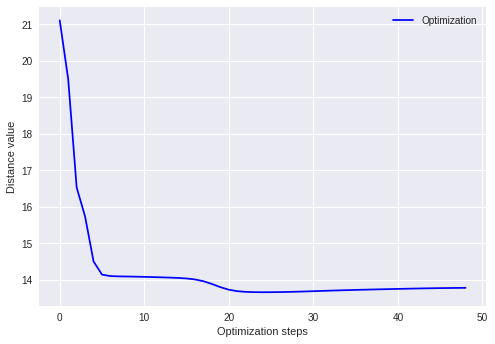


_______________________________________
_______________________________________


 Layer count in Circuit => 3

 Iteration used => 49
 Minimum distance => 13.784323654694834
 Time taken for optimization (minute) => 1.7004424611727396


In [39]:
layer = 3
simulate(layer)

# No. of Layers in the circuit = 4

Optimizing
.Iteration=> 0, distance=> 21.06404228207292
.Iteration=> 1, distance=> 16.817639188553166
.Iteration=> 2, distance=> 15.192967844310157
.Iteration=> 3, distance=> 14.6116109666796
.Iteration=> 4, distance=> 14.117695270267287
.Iteration=> 5, distance=> 13.856779761056748
.Iteration=> 6, distance=> 13.72369790695645
.Iteration=> 7, distance=> 13.632222510037163
.Iteration=> 8, distance=> 13.573479738444318
.Iteration=> 9, distance=> 13.537515049526272
.Iteration=> 10, distance=> 13.513589986579952
.Iteration=> 11, distance=> 13.495469755284201
.Iteration=> 12, distance=> 13.480835380463812
.Iteration=> 13, distance=> 13.469072519716104
.Iteration=> 14, distance=> 13.459907238545767
.Iteration=> 15, distance=> 13.452986023327176
.Iteration=> 16, distance=> 13.447883170257422
.Iteration=> 17, distance=> 13.444186049600965
.Iteration=> 18, distance=> 13.441544899466624
.Iteration=> 19, distance=> 13.43968389558034
.Iteration=> 20, distance=> 13.438393144448035

Optimization Com

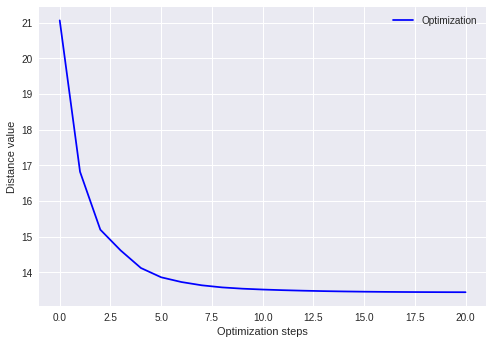


_______________________________________
_______________________________________


 Layer count in Circuit => 4

 Iteration used => 21
 Minimum distance => 13.438393144448035
 Time taken for optimization (minute) => 1.5532435655593873


In [40]:
layer = 4
simulate(layer)

# No. of Layers in the circuit = 5

Optimizing
.Iteration=> 0, distance=> 19.716797421752347
.Iteration=> 1, distance=> 17.24400537790286
.Iteration=> 2, distance=> 14.133387768234234
.Iteration=> 3, distance=> 13.122138913927103
.Iteration=> 4, distance=> 12.98828610766316
.Iteration=> 5, distance=> 12.913457746096668
.Iteration=> 6, distance=> 12.842598865346643
.Iteration=> 7, distance=> 12.782251724518309
.Iteration=> 8, distance=> 12.736066343240774
.Iteration=> 9, distance=> 12.704344782378799
.Iteration=> 10, distance=> 12.684823587734275
.Iteration=> 11, distance=> 12.673564038179407
.Iteration=> 12, distance=> 12.667069594070757
.Iteration=> 13, distance=> 12.662941375045659
.Iteration=> 14, distance=> 12.659589521615072
.Iteration=> 15, distance=> 12.65592843583709
.Iteration=> 16, distance=> 12.651205483393282
.Iteration=> 17, distance=> 12.644899032024153
.Iteration=> 18, distance=> 12.636657645227075
.Iteration=> 19, distance=> 12.626280297958456
.Iteration=> 20, distance=> 12.613740094378542
.Iteration=> 21

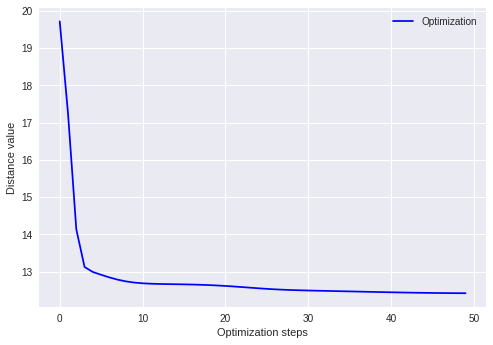


_______________________________________
_______________________________________


 Layer count in Circuit => 5

 Iteration used => 50
 Minimum distance => 12.418574292597413
 Time taken for optimization (minute) => 6.810161904493968


In [47]:
layer = 5
simulate(layer)

# No. of Layers in the circuit = 6

Optimizing
.Iteration=> 0, distance=> 19.897236620215878
.Iteration=> 1, distance=> 17.6053030793202
.Iteration=> 2, distance=> 14.036303299852992
.Iteration=> 3, distance=> 13.590233178930868
.Iteration=> 4, distance=> 13.262015606286525
.Iteration=> 5, distance=> 13.113154616797548
.Iteration=> 6, distance=> 13.011877660847423
.Iteration=> 7, distance=> 12.970928973273745
.Iteration=> 8, distance=> 12.957883279488872
.Iteration=> 9, distance=> 12.948310709528805
.Iteration=> 10, distance=> 12.939529348523461
.Iteration=> 11, distance=> 12.930316154504698
.Iteration=> 12, distance=> 12.918667726734597
.Iteration=> 13, distance=> 12.902021660878535
.Iteration=> 14, distance=> 12.877460306165863
.Iteration=> 15, distance=> 12.843255794221111
.Iteration=> 16, distance=> 12.802791002904883
.Iteration=> 17, distance=> 12.766570639598754
.Iteration=> 18, distance=> 12.74417048163805
.Iteration=> 19, distance=> 12.735082132699011
.Iteration=> 20, distance=> 12.732476651687284
.Iteration=> 21

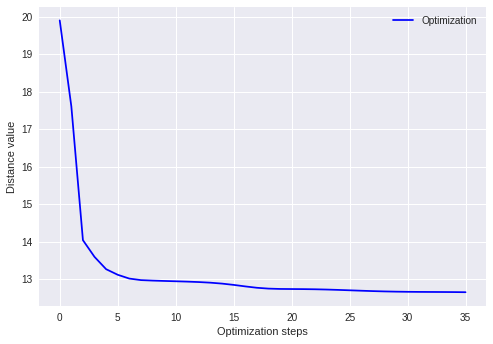


_______________________________________
_______________________________________


 Layer count in Circuit => 6

 Iteration used => 36
 Minimum distance => 12.647976948841578
 Time taken for optimization (minute) => 7.78284680445989


In [48]:
layer = 6
simulate(layer)

# No. of Layers in the circuit = 7

Optimizing
.Iteration=> 0, distance=> 18.875139796039235
.Iteration=> 1, distance=> 17.62215802768832
.Iteration=> 2, distance=> 15.254840521061343
.Iteration=> 3, distance=> 13.477533968499465
.Iteration=> 4, distance=> 12.923943049048706
.Iteration=> 5, distance=> 12.787700322296596
.Iteration=> 6, distance=> 12.743216625265637
.Iteration=> 7, distance=> 12.72089364220982
.Iteration=> 8, distance=> 12.693495901399698
.Iteration=> 9, distance=> 12.658710323215473
.Iteration=> 10, distance=> 12.622737346253
.Iteration=> 11, distance=> 12.58770635236839
.Iteration=> 12, distance=> 12.550971423721087
.Iteration=> 13, distance=> 12.509568847747655
.Iteration=> 14, distance=> 12.46389043694446
.Iteration=> 15, distance=> 12.418357013671585
.Iteration=> 16, distance=> 12.378618237888201
.Iteration=> 17, distance=> 12.34775023579498
.Iteration=> 18, distance=> 12.325733986482883
.Iteration=> 19, distance=> 12.311120321388483
.Iteration=> 20, distance=> 12.301813577740361
.Iteration=> 21, dis

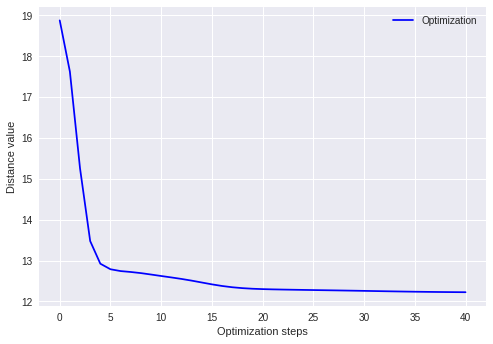


_______________________________________
_______________________________________


 Layer count in Circuit => 7

 Iteration used => 41
 Minimum distance => 12.22615699513117
 Time taken for optimization (minute) => 13.903959433237711


In [49]:
layer = 7
simulate(layer)

# No. of Layers in the circuit = 8

Optimizing
.Iteration=> 0, distance=> 19.628131608211184
.Iteration=> 1, distance=> 17.67191378638802
.Iteration=> 2, distance=> 14.39660553793875
.Iteration=> 3, distance=> 13.208458226291881
.Iteration=> 4, distance=> 12.902064437094346
.Iteration=> 5, distance=> 12.742807142026479
.Iteration=> 6, distance=> 12.656430091464099
.Iteration=> 7, distance=> 12.607386916433127
.Iteration=> 8, distance=> 12.561160629855191
.Iteration=> 9, distance=> 12.50747183643382
.Iteration=> 10, distance=> 12.43973168884526
.Iteration=> 11, distance=> 12.377366874915033
.Iteration=> 12, distance=> 12.347336938923574
.Iteration=> 13, distance=> 12.33292782209615
.Iteration=> 14, distance=> 12.318488567327288
.Iteration=> 15, distance=> 12.302392194902957
.Iteration=> 16, distance=> 12.286735138592201
.Iteration=> 17, distance=> 12.27335621583881
.Iteration=> 18, distance=> 12.262950159326504
.Iteration=> 19, distance=> 12.255467027359709
.Iteration=> 20, distance=> 12.25062635526968
.Iteration=> 21, di

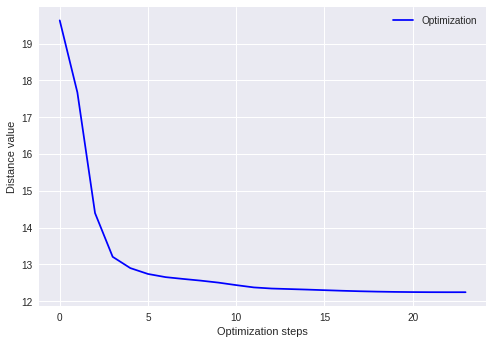


_______________________________________
_______________________________________


 Layer count in Circuit => 8

 Iteration used => 24
 Minimum distance => 12.247375090691012
 Time taken for optimization (minute) => 11.646444984277089


In [51]:
layer = 8
simulate(layer)

# No. of Layers in the circuit = 9

Optimizing
.Iteration=> 0, distance=> 18.647710163775614
.Iteration=> 1, distance=> 17.859442043239376
.Iteration=> 2, distance=> 14.52651561887458
.Iteration=> 3, distance=> 13.582474143646845
.Iteration=> 4, distance=> 12.950840145432064
.Iteration=> 5, distance=> 12.825773531917623
.Iteration=> 6, distance=> 12.750251865980559
.Iteration=> 7, distance=> 12.656383201401134
.Iteration=> 8, distance=> 12.55162833187482
.Iteration=> 9, distance=> 12.448726901444319
.Iteration=> 10, distance=> 12.365162640805952
.Iteration=> 11, distance=> 12.316507325452847
.Iteration=> 12, distance=> 12.29269244232883
.Iteration=> 13, distance=> 12.279341266044202
.Iteration=> 14, distance=> 12.27080566359278
.Iteration=> 15, distance=> 12.265423046378896
.Iteration=> 16, distance=> 12.26241542334354
.Iteration=> 17, distance=> 12.261038653065164
.Iteration=> 18, distance=> 12.260324161126363
.Iteration=> 19, distance=> 12.259304675406902

Optimization Completed


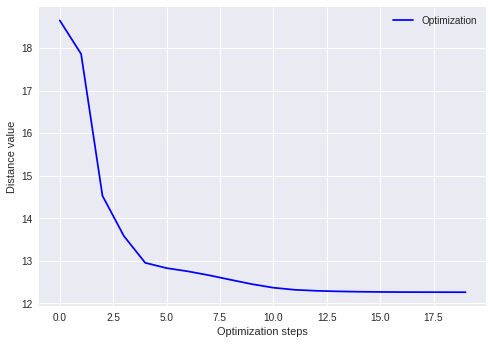


_______________________________________
_______________________________________


 Layer count in Circuit => 9

 Iteration used => 20
 Minimum distance => 12.259304675406902
 Time taken for optimization (minute) => 13.859201765060424


In [52]:
layer = 9
simulate(layer)

# No. of Layers in the circuit = 10

Optimizing
.Iteration=> 0, distance=> 20.87537369697013
.Iteration=> 1, distance=> 17.056675017632653
.Iteration=> 2, distance=> 13.77902863582848
.Iteration=> 3, distance=> 13.274862237934453
.Iteration=> 4, distance=> 13.11117066192816
.Iteration=> 5, distance=> 12.91431183990102
.Iteration=> 6, distance=> 12.775236181837794
.Iteration=> 7, distance=> 12.65369375131403
.Iteration=> 8, distance=> 12.554942342509918
.Iteration=> 9, distance=> 12.477652038395501
.Iteration=> 10, distance=> 12.41868675370673
.Iteration=> 11, distance=> 12.374569687554521
.Iteration=> 12, distance=> 12.344704681241968
.Iteration=> 13, distance=> 12.327908814339612
.Iteration=> 14, distance=> 12.319976393097779
.Iteration=> 15, distance=> 12.316165973818688
.Iteration=> 16, distance=> 12.313615238340347
.Iteration=> 17, distance=> 12.31082266444156
.Iteration=> 18, distance=> 12.306514782621196
.Iteration=> 19, distance=> 12.299623325981988
.Iteration=> 20, distance=> 12.290385574335403
.Iteration=> 21, di

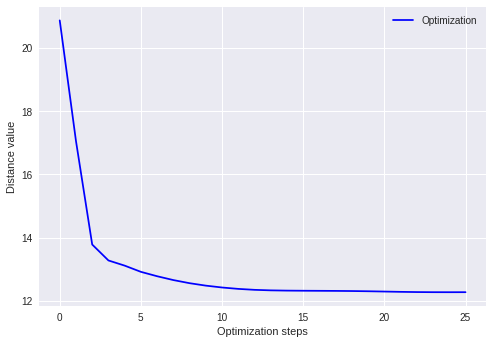


_______________________________________
_______________________________________


 Layer count in Circuit => 10

 Iteration used => 26
 Minimum distance => 12.270290603551086
 Time taken for optimization (minute) => 24.005946644147237


In [58]:
layer = 10
simulate(layer)

# No. of Layers in the circuit = 11

Optimizing
.Iteration=> 0, distance=> 18.841326726329747
.Iteration=> 1, distance=> 18.35906712968393
.Iteration=> 2, distance=> 14.689355765971053
.Iteration=> 3, distance=> 13.05367631352275
.Iteration=> 4, distance=> 12.674700838809896
.Iteration=> 5, distance=> 12.463005444979453
.Iteration=> 6, distance=> 12.365762094341278
.Iteration=> 7, distance=> 12.30762301511231
.Iteration=> 8, distance=> 12.271764966101443
.Iteration=> 9, distance=> 12.250650437028948
.Iteration=> 10, distance=> 12.239718893176308
.Iteration=> 11, distance=> 12.235002625817245
.Iteration=> 12, distance=> 12.233151977545498
.Iteration=> 13, distance=> 12.232335344176654
.Iteration=> 14, distance=> 12.23185801382193
.Iteration=> 15, distance=> 12.231531646336355

Optimization Completed


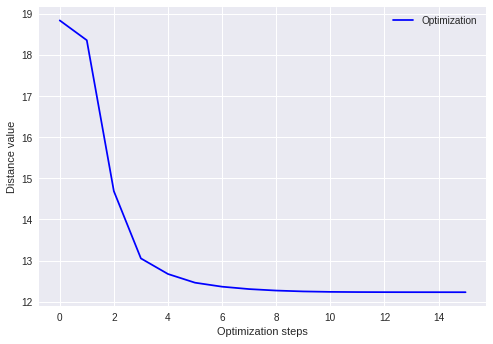


_______________________________________
_______________________________________


 Layer count in Circuit => 11

 Iteration used => 16
 Minimum distance => 12.231531646336355
 Time taken for optimization (minute) => 19.50881061156591


In [59]:
layer = 11
simulate(layer)

# No. of Layers in the circuit = 12

Optimizing
.Iteration=> 0, distance=> 20.832188091023085
.Iteration=> 1, distance=> 17.46911978495071
.Iteration=> 2, distance=> 13.928728102962424
.Iteration=> 3, distance=> 12.737319665781024
.Iteration=> 4, distance=> 12.530574221004331
.Iteration=> 5, distance=> 12.385059228964714
.Iteration=> 6, distance=> 12.28156793654951
.Iteration=> 7, distance=> 12.224552227838211
.Iteration=> 8, distance=> 12.197263839578731
.Iteration=> 9, distance=> 12.181494521681968
.Iteration=> 10, distance=> 12.171973813277594
.Iteration=> 11, distance=> 12.168541291953478
.Iteration=> 12, distance=> 12.168301674271085
.Iteration=> 13, distance=> 12.168308347587214

Optimization Completed


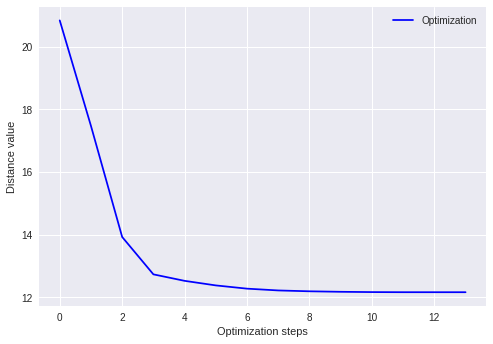


_______________________________________
_______________________________________


 Layer count in Circuit => 12

 Iteration used => 14
 Minimum distance => 12.168308347587214
 Time taken for optimization (minute) => 21.846366838614145


In [60]:
layer = 12
simulate(layer)

# Final Plot - Plot of Minimum distance as a function of no. of layers used in the circuit

# Points to observe - 
## 1. In the plot below, starting from the circuit having 7 layers, upto the last i.e. 12 layers, the minimum distance has become same almost
## 2. Also from a specific circuit to the next circuit, minimum distance has been decreased except in the case of circuit with 5 layers to circuit with 6

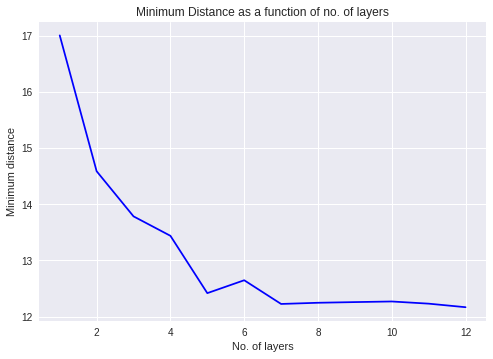

In [61]:
# plots minimum distance as a function of no. of layers used in the circuit
plt.style.use("seaborn")
plt.plot(np.arange(1,layer+1),min_distance_list, "b")
plt.ylabel("Minimum distance")
plt.xlabel("No. of layers")
plt.title("Minimum Distance as a function of no. of layers")
plt.show()



# Plot of iteration as a function of no. of layers used in the circuit

## Although we have mentioned the no. of iterations while calling the optimize() function, but due the callback, earlystopping has occured in almost all cases. 
## The no. of iteration used has also been placed as a function of layers in the circuit
## Although their is no intuition has been achieved from the plot, from 7 upto 12 we can observe decrement in iteration, except in the case 9-10

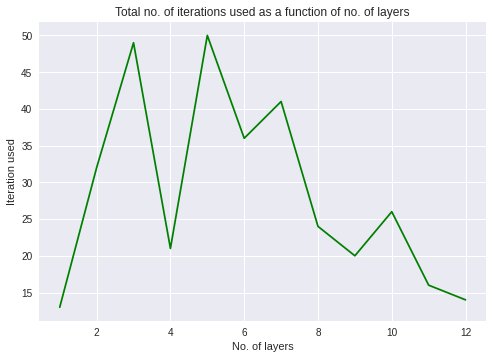

In [62]:
# plots the no. of iterations used as a function of no. of layers in the specific circuit
plt.plot(np.arange(1,layer+1),iter_list, "g")
plt.ylabel("Iteration used")
plt.xlabel("No. of layers")
plt.title("Total no. of iterations used as a function of no. of layers")
plt.show()

# Plot of Time taken to optimize as a function of no. of layers used in the circuit

## It is obvious that with incresing the no. of parameterized gates in the circuit, time taken for optimization will also be increasing.

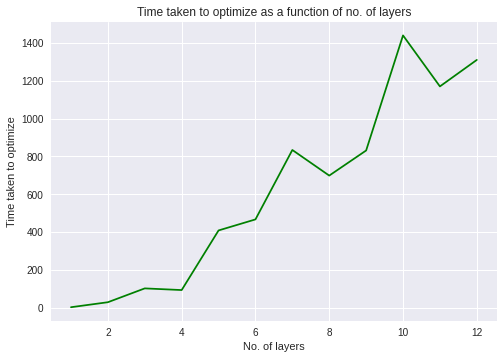

In [63]:
# plots the time taken for optimization as a function of no. of layers in the specific circuit
plt.plot(np.arange(1,layer+1),time_list, "g")
plt.ylabel("Time taken to optimize")
plt.xlabel("No. of layers")
plt.title("Time taken to optimize as a function of no. of layers")
plt.show()